In [1]:
pip install fredapi

In [2]:
pip install statsmodels>=0.13.0 matplotlib>=3.5.0 seaborn>=0.11.0 scikit-learn>=1.0.0 pandas-datareader>=0.10.0 requests>=2.25.1 python-dateutil>=2.8.1 pytz>=2021.1

In [3]:
# Database configuration
DATABASE_CONFIG = {
    'db_path': 'data/economic_data.db',
    'table_name': 'economic_data'
}

# Data source configuration
DATA_SOURCE_CONFIG = {
    'fred': {
        'gdp_series': 'GDP',
        'interest_rate_series': 'FEDFUNDS',
        'imports_series': 'IMPGS'
    }
}

# Model configuration
MODEL_CONFIG = {
    'max_lags': 5,
    'forecast_steps': 12,
    'test_size': 0.2
}

# File path configuration
FILE_PATHS = {
    'data_dir': 'data',
    'output_dir': 'output',
    'plots_dir': 'output/plots',
    'reports_dir': 'output/reports'
}

# Create necessary directories
import os
for path in FILE_PATHS.values():
    os.makedirs(path, exist_ok=True)

# FRED API configuration
FRED_API_KEY = "edac3221c53f506ba084ad306d22a343"

# Data configuration
SERIES_IDS = {
    'imports': 'IMPGS',           # Total imports
    'gdp': 'GDP',                 # GDP
    'industrial_production': 'INDPRO',  # Industrial production index
    'unemployment': 'UNRATE',     # Unemployment rate
    'cpi': 'CPIAUCSL',           # Consumer price index
    'exchange_rate': 'DEXCHUS'    # USD/CNY exchange rate
}

# Data time range
START_DATE = '2010-01-01'
END_DATE = '2024-01-01'

In [6]:
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [7]:
import pandas as pd
import numpy as np
from fredapi import Fred
from datetime import datetime
import os
from config import FRED_API_KEY, SERIES_IDS, START_DATE, END_DATE

class DataProcessor:
    def __init__(self):
        self.fred = Fred(api_key=FRED_API_KEY)
        self.data = None

    def fetch_fred_data(self):
        """Fetch economic data from FRED"""
        print("Starting to fetch data from FRED...")
        data_frames = {}

        for name, series_id in SERIES_IDS.items():
            try:
                print(f"Fetching {name} data...")
                series = self.fred.get_series(series_id, START_DATE, END_DATE)
                data_frames[name] = series
                print(f"{name} data fetched successfully!")
            except Exception as e:
                print(f"Failed to fetch {name} data: {str(e)}")

        # Combine all data into one DataFrame
        self.data = pd.DataFrame(data_frames)

        # Handle missing values
        self.data = self.data.fillna(method='ffill').fillna(method='bfill')

        # Ensure quarterly frequency
        self.data = self.data.resample('Q').mean()

        return self.data

    def save_data(self):
        """Save processed data"""
        if self.data is not None:
            # Ensure data directory exists
            os.makedirs('data', exist_ok=True)

            # Save data to CSV file
            self.data.to_csv('data/economic_data.csv')
            print("Data saved to data/economic_data.csv")
        else:
            print("No data to save!")

    def process_data(self):
        """Main data processing workflow"""
        try:
            # Fetch FRED data
            self.fetch_fred_data()

            # Save processed data
            self.save_data()

            print("Data processing completed!")
            return True
        except Exception as e:
            print(f"Data processing failed: {str(e)}")
            return False

if __name__ == "__main__":
    processor = DataProcessor()
    processor.process_data()

Starting to fetch data from FRED...
Fetching imports data...
imports data fetched successfully!
Fetching gdp data...
gdp data fetched successfully!
Fetching industrial_production data...
industrial_production data fetched successfully!
Fetching unemployment data...
unemployment data fetched successfully!
Fetching cpi data...
cpi data fetched successfully!
Fetching exchange_rate data...
exchange_rate data fetched successfully!
Data saved to data/economic_data.csv
Data processing completed!


<ipython-input-7-00bc87a62457>:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data = self.data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-7-00bc87a62457>:34: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  self.data = self.data.resample('Q').mean()


Data loaded successfully!

Checking stationarity for imports:
ADF Statistic: -0.707745
p-value: 0.844733
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
imports is not stationary, performing differencing

Checking stationarity for gdp:
ADF Statistic: 1.760026
p-value: 0.998266
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
gdp is not stationary, performing differencing

Checking stationarity for industrial_production:
ADF Statistic: -3.133415
p-value: 0.024177
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595

Checking stationarity for unemployment:
ADF Statistic: -2.679055
p-value: 0.077733
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
unemployment is not stationary, performing differencing

Checking stationarity for cpi:
ADF Statistic: 2.660266
p-value: 0.999084
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600
cpi is not stationary, performing differencing

Checking stationarity for exchange_rate:
ADF Statistic: -1.987639
p-value: 0.292019
Critical Value

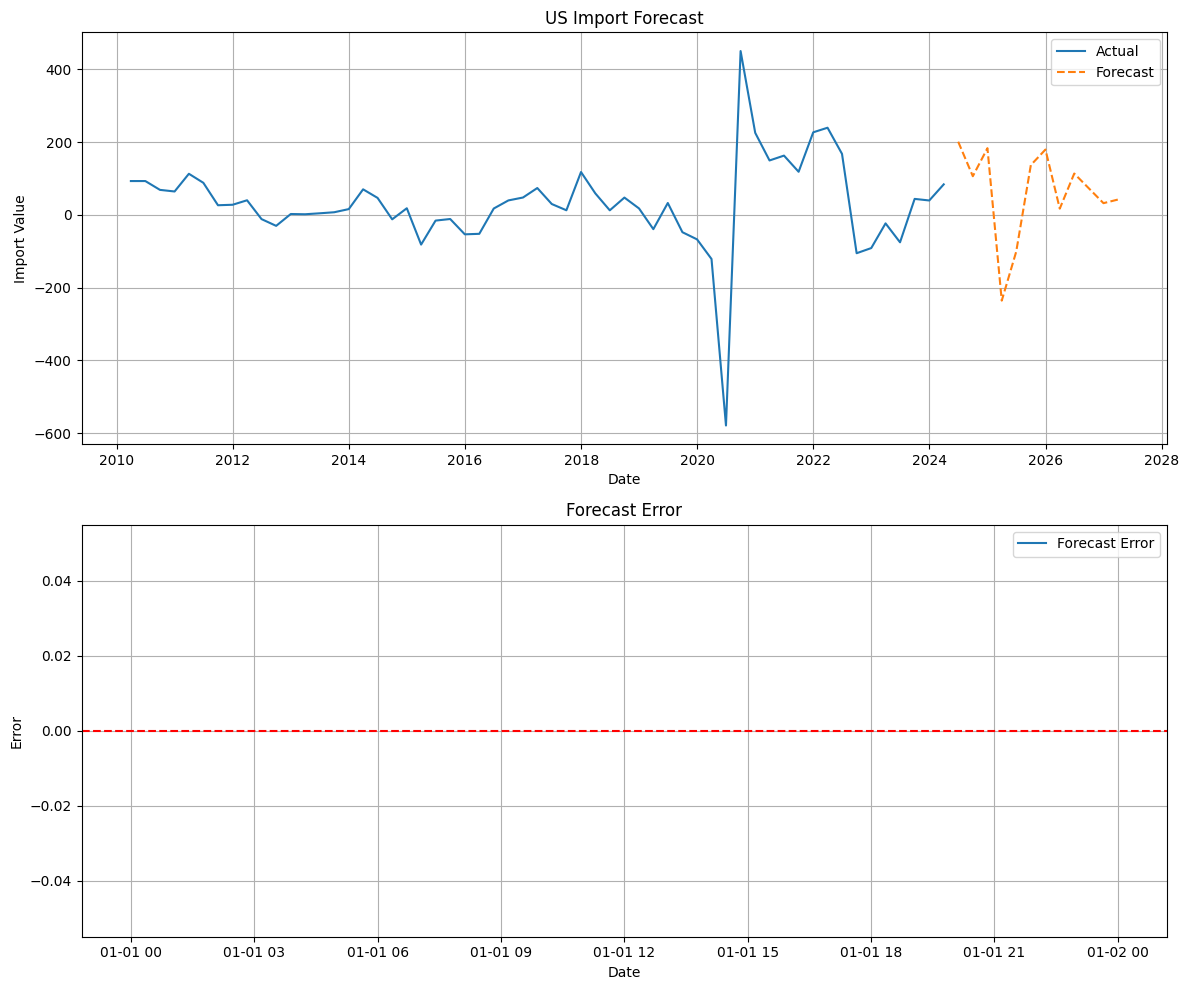

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, coint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

class USImportForecast:
    def __init__(self):
        self.data = None
        self.model = None
        self.forecast_results = None
        self.cointegration_results = None

    def load_data(self, data_path):
        """Load data"""
        try:
            self.data = pd.read_csv(data_path, index_col=0, parse_dates=True)
            # Handle missing values and infinite values
            self.data = self.data.replace([np.inf, -np.inf], np.nan)
            self.data = self.data.fillna(method='ffill').fillna(method='bfill')
            print("Data loaded successfully!")
            return True
        except Exception as e:
            print(f"Data loading failed: {str(e)}")
            return False

    def check_stationarity(self, series):
        """Check time series stationarity"""
        series = series.dropna()
        result = adfuller(series)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        return result[1] < 0.05

    def check_cointegration(self, series1, series2):
        """Check cointegration relationship"""
        # Ensure no missing values
        series1 = series1.dropna()
        series2 = series2.dropna()
        # Ensure same length
        min_len = min(len(series1), len(series2))
        series1 = series1[-min_len:]
        series2 = series2[-min_len:]

        result = coint(series1, series2)
        print('Cointegration Test Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        return result[1] < 0.05

    def prepare_data(self):
        """Data preprocessing"""
        if self.data is None:
            print("Please load data first!")
            return False

        # Check stationarity
        for column in self.data.columns:
            print(f"\nChecking stationarity for {column}:")
            if not self.check_stationarity(self.data[column]):
                print(f"{column} is not stationary, performing differencing")
                self.data[column] = self.data[column].diff().dropna()

        # Check cointegration
        print("\nChecking cointegration relationships:")
        self.cointegration_results = {}
        for col in self.data.columns:
            if col != 'imports':
                print(f"\nChecking cointegration between imports and {col}:")
                self.cointegration_results[col] = self.check_cointegration(
                    self.data['imports'], self.data[col])

        # Handle missing values again
        self.data = self.data.fillna(method='ffill').fillna(method='bfill')
        return True

    def fit_model(self, max_lags=5):
        """Fit model"""
        if self.data is None:
            print("Please load data first!")
            return False

        # Check for cointegration
        has_cointegration = any(self.cointegration_results.values())

        if has_cointegration:
            print("\nCointegration detected, using VECM model")
            # Select optimal lag order
            model = VECM(self.data, k_ar_diff=max_lags)
            self.model = model.fit()
            print("\nVECM model fitting results:")
            print(self.model.summary())
        else:
            print("\nNo cointegration detected, using VAR model")
            # Select optimal lag order
            model = VAR(self.data)
            results = model.select_order(max_lags)
            print("\nOptimal lag order selection results:")
            print(results.summary())

            # Fit VAR model
            self.model = model.fit(maxlags=max_lags)
            print("\nVAR model fitting results:")
            print(self.model.summary())

        return True

    def granger_causality_test(self, max_lags=5):
        """Perform Granger causality test"""
        if self.data is None:
            print("Please load data first!")
            return False

        print("\nGranger causality test results:")
        for column in self.data.columns:
            if column != 'imports':
                print(f"\nTesting if {column} is Granger cause of imports:")
                test_result = grangercausalitytests(self.data[['imports', column]], max_lags)
                for lag in range(1, max_lags+1):
                    print(f"Lag {lag}:")
                    print(f"F-statistic: {test_result[lag][0]['ssr_ftest'][0]}")
                    print(f"P-value: {test_result[lag][0]['ssr_ftest'][1]}")

        return True

    def forecast(self, steps=12):
        """Generate forecasts"""
        if self.model is None:
            print("Please fit the model first!")
            return False

        try:
            # Try to use predict method for forecasting
            self.forecast_results = self.model.predict(steps=steps)
            forecast_index = pd.date_range(start=self.data.index[-1], periods=steps+1, freq='Q')[1:]
            self.forecast_results = pd.DataFrame(self.forecast_results,
                                              index=forecast_index,
                                              columns=self.data.columns)
            return True
        except Exception as e:
            print(f"Forecasting failed: {str(e)}")
            return False

    def evaluate_model(self):
        """Evaluate model performance"""
        if self.forecast_results is None:
            print("Please generate forecasts first!")
            return False

        # Calculate forecast errors
        mse = mean_squared_error(self.data['imports'][-len(self.forecast_results):],
                                self.forecast_results['imports'])
        mae = mean_absolute_error(self.data['imports'][-len(self.forecast_results):],
                                 self.forecast_results['imports'])

        print("\nModel evaluation results:")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")

        return True

    def plot_results(self):
        """Plot results"""
        if self.forecast_results is None:
            print("Please generate forecasts first!")
            return False

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Plot forecast results
        ax1.plot(self.data.index, self.data['imports'], label='Actual')
        ax1.plot(self.forecast_results.index, self.forecast_results['imports'],
                label='Forecast', linestyle='--')
        ax1.set_title('US Import Forecast')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Import Value')
        ax1.legend()
        ax1.grid(True)

        # Plot forecast errors
        error = self.data['imports'][-len(self.forecast_results):] - self.forecast_results['imports']
        ax2.plot(error.index, error, label='Forecast Error')
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_title('Forecast Error')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Error')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

        return True

if __name__ == "__main__":
    # Create model instance
    model = USImportForecast()

    # Load data
    model.load_data("data/economic_data.csv")

    # Data preprocessing
    model.prepare_data()

    # Fit model
    model.fit_model()

    # Perform Granger causality test
    model.granger_causality_test()

    # Generate forecasts
    model.forecast()

    # Evaluate model
    model.evaluate_model()

    # Plot results
    model.plot_results()